In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
import jax.numpy as jnp
from jax import grad
from jax import random

In [2]:
def softmax_prob_forloop(W, b, inputs): #output is datalen-by-C 
    # inputs is is dim-by-datalen
    # b is C-dimensional vector W is (C-by-dim)
    dim, datalen = np.shape(inputs)
    c = len(b)
    score = np.zeros((c, datalen))
    for ci in range(c):
        for lj in range((datalen)):
            score[ci, lj] = b[ci]
            for dk in range(dim):
                score[ci, lj] += W[ci, dk]*inputs[dk, lj]
    maxes = np.zeros(datalen)
    for lj in range(datalen):
        maxes[lj] = np.max(score[:, lj])
    for ci in range(c):
        for lj in range(datalen):
            score[ci, lj] = score[ci, lj] - maxes[lj]
    expscore = np.exp(score)
    norm_factor = np.diag(1/np.sum(expscore, axis=0))
    return np.dot(expscore, norm_factor).T

def softmax_prob1(W, b, inputs): # output is datalen-by-C
    # inputs is dim-by-datalen
    # b is C-dimensional vector W is (C-by-dim)
    # Make sure all numerical operations are from JAX, so 'jnp', not 'np'
    datalen = jnp.shape(inputs)[1]
    c = len(b)
    linear_part = jnp.dot(W,inputs)
    large = jnp.max(linear_part, axis=0)
    bias_offset = jnp.dot(jnp.diag(b), jnp.ones((c,datalen)))
    large_offset = jnp.dot(np.ones((c,datalen)), jnp.diag(large))
    expscore = jnp.exp(linear_part + bias_offset - large_offset)
    norm_factor = jnp.diag(1/jnp.sum(expscore, axis=0))
    return jnp.dot(expscore, norm_factor).T

In [3]:
def softmax_prob(W, inputs):
    datalen = jnp.shape(inputs)[1]
    c = len(W)
    inputs = jnp.concatenate((jnp.ones((1,datalen)), inputs), axis=0)
    score = jnp.dot(W,inputs)
    large = jnp.max(score, axis=0)
    large_offset = jnp.dot(np.ones((c,datalen)),jnp.diag(large))
    expscore = jnp.exp(score - large_offset)
    norm_factor = jnp.diag(1/jnp.sum(expscore, axis=0))
    return jnp.dot(expscore, norm_factor).T

In [4]:
def softmax_xentropy(Wb, inputs, targets, num_classes):
    epsilon = 1e-8
    ys = get_one_hot(targets, num_classes)
    logprobs=-jnp.log(softmax_prob(Wb,inputs)+epsilon)
    return jnp.mean(ys*logprobs)

In [5]:
def get_one_hot(targets, num_classes):
    res = jnp.eye(num_classes)[jnp.array(targets).reshape(-1)]
    return res.reshape(list(targets.shape)+[num_classes])

In [6]:
Wb = jnp.array([[-3., 1.3, 2.0, -1.0], [-6., -2., -3., 1.5], [1., 2.0, 2.0, 2.5], [3., 4.0, 4.0, -2.5]])
inputs = jnp.array([[0.52, 1.12,  0.77],
                    [3.82, -6.11, 3.15],
                   [0.88, -1.08, 0.15],
                   [0.52, 0.06, -1.30],
                   [0.74, -2.49, 1.39],
                   [0.14, -0.43, -1.69]]).T

targets = jnp.array([0, 1, 3, 2, 1, 2])

/home/benjamin/anaconda3/lib/python3.8/site-packages/jax/lib/xla_bridge.py:130: UserWarning: No GPU/TPU found, falling back to CPU.
  warnings.warn('No GPU/TPU found, falling back to CPU.')


In [7]:
key = random.PRNGKey(0)
key, W_key = random.split(key, 2)
[classes, dim] = 4,3
Winit = random.normal(W_key, (classes, dim+1))
print(Winit)

[[ 0.20820066 -1.0580499  -0.29374585 -0.44117254]
 [ 0.2366984  -0.03426386 -1.0025561   1.1560111 ]
 [-0.5381381  -0.48968917  0.24939033 -1.4128867 ]
 [ 1.8543106   0.22756499  0.49751544 -2.089685  ]]


In [8]:
def grad_descent(Wb, inputs, targets, num_classes, lrate, nsteps):
    W1 = Wb
    Whist = [W1]
    losshist= [softmax_xentropy(W1, inputs, targets, num_classes)]
    eta = lrate
    for i in range(nsteps):
        gWb = grad(softmax_xentropy, (0))(W1, inputs, targets, num_classes)
        W1= W1 - eta*gWb
        if (i%5 == 0):
            Whist.append(W1)
            losshist.append(softmax_xentropy(W1, inputs, targets, num_classes))
    Whist.append(W1)
    losshist.append(softmax_xentropy(W1, inputs, targets, num_classes))
    return W1, Whist, losshist

In [9]:
W2, Whist, losshist = grad_descent(Winit, inputs, targets, 4, 0.75, 200)

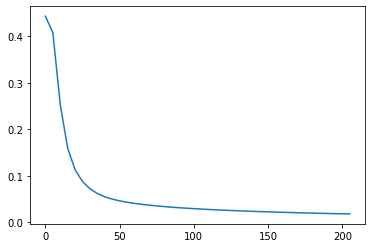

In [10]:
plt.plot([5*i for i in range(len(losshist))], losshist)

In [11]:
print('From:\n', np.around(softmax_prob(Winit, inputs),3))
print('To:\n', np.around(softmax_prob(W2, inputs),3))
print('Target:\n', get_one_hot(targets,4))

From:
 [[0.09  0.243 0.05  0.618]
 [0.    1.    0.    0.   ]
 [0.073 0.507 0.028 0.392]
 [0.011 0.002 0.025 0.962]
 [0.008 0.99  0.    0.002]
 [0.013 0.001 0.028 0.957]]
To:
 [[0.951 0.009 0.006 0.034]
 [0.    0.996 0.    0.004]
 [0.025 0.13  0.043 0.802]
 [0.004 0.    0.949 0.047]
 [0.001 0.926 0.    0.074]
 [0.    0.    0.979 0.021]]
Target:
 [[1. 0. 0. 0.]
 [0. 1. 0. 0.]
 [0. 0. 0. 1.]
 [0. 0. 1. 0.]
 [0. 1. 0. 0.]
 [0. 0. 1. 0.]]


In [14]:
inputs = np.random.normal(5,3,(6,3)).T
print(inputs)

[[ 8.34465098  0.03420167 11.56621949  3.93699153  5.1085756   3.53314691]
 [ 4.94346001  2.28933473  3.54606153  5.96047527  6.26964192  7.77815184]
 [ 2.9334579  -0.1418554   2.52225997 10.71165975 11.16838271  6.06075946]]


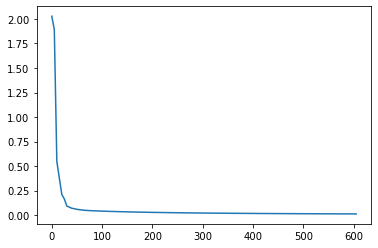

In [17]:
targets = jnp.array([0,3,3,2,2,1])
W3, Whist2, losshist2 = grad_descent(Winit, inputs, targets, 4,0.5, 600)
plt.plot([5*i for i in range(len(losshist2))], losshist2)

In [18]:
print('From:\n', np.around(softmax_prob(Winit, inputs),3))
print('To:\n', np.around(softmax_prob(W3, inputs),3))
print('Target:\n', get_one_hot(targets,4))

From:
 [[0.    0.155 0.    0.845]
 [0.022 0.004 0.043 0.931]
 [0.    0.144 0.    0.856]
 [0.    1.    0.    0.   ]
 [0.    1.    0.    0.   ]
 [0.    0.995 0.    0.004]]
To:
 [[0.911 0.008 0.002 0.079]
 [0.037 0.041 0.    0.921]
 [0.059 0.    0.    0.941]
 [0.    0.007 0.993 0.   ]
 [0.    0.004 0.996 0.   ]
 [0.017 0.973 0.009 0.   ]]
Target:
 [[1. 0. 0. 0.]
 [0. 0. 0. 1.]
 [0. 0. 0. 1.]
 [0. 0. 1. 0.]
 [0. 0. 1. 0.]
 [0. 1. 0. 0.]]
